# Fugue with BigQuery

Have questions? Chat with us on Github or Slack:

[![Homepage](https://img.shields.io/badge/fugue-source--code-red?logo=github)](https://github.com/fugue-project/fugue)
[![Slack Status](https://img.shields.io/badge/slack-join_chat-white.svg?logo=slack&style=social)](http://slack.fugue.ai)

The Fugue BigQuery integration provides the following benefits:

* significantly faster development of SQL queries
* ability to break up pieces of logic
* ability to test SQL without running on the warehouse
* for Python-users, reduced boilerplate when querying warehouse data for further manipulation in Python engines (Pandas, Spark, Dask, Ray)

This page is divided into three parts: setup, SQL usage, and Python usage of the BigQuery integration.

## Setup

Some of the configurations can be set using the `engine_conf` Fugue uses. For more information on configuring engines, see the section on [engine initialization](https://fugue-tutorials.readthedocs.io/tutorials/advanced/execution_engine.html#initialization). An example can be found below when creatingthe `BigQuery` client.

### Installation

To install the Fugue BigQuery integration, `fugue-warehouses` needs to be installed separately. Note that `fugue-warehouses` only supports Python 3.8 and up.

```
pip install fugue-warehouses[bigquery]
```

### Authenticating with Google Cloud

The most common way is to use the [default credentials](https://cloud.google.com/docs/authentication/application-default-credentials). Make sure the `GOOGLE_APPLICATION_CREDENTIALS` is set to a credential file. You can also read the [authentication doc](https://cloud.google.com/bigquery/docs/authentication) of BigQuery. If you are using a distributed cluster with Spark, Dask, or Ray, all of the machines in teh cluster need to be authenticated. **The credentials need permissions for BigQuery.**

An alternative way is to keep the [service account credential json](https://developers.google.com/workspace/guides/create-credentials#service-account) as a string in an environment variable, then in Fugue configs, set `fugue.bq.credentials.env` to point to the environment variable. In this way, you only need to configure your local environment. The credential will be propagated to the compute cluster when the application is running. 

Some platforms have their own way to inject the credentials into your environment. For example [this](https://cloud.google.com/bigquery/docs/connect-databricks) is how Databricks users enable the service account on a cluster. If you already authenticated this way, you don't need extra steps to authenticate for Fugue.

### Environment Requirement

The Fugue BigQuery integration will sometimes persist intermediate tables to either prevent querying data again, or in order to pass the data to distributed backends.

You MUST set a dataset to store temporary intermediate tables. The default dataset name is `FUGUE_TEMP_DATASET`. You can change it through the Fugue config `fugue.bq.temp_dataset`. It is strongly recommended to set a default expiration for this dataset, `1 day` is a reasonable value. An example of using the Fugue configuration can be found below when creating the `BigQueryClient`.

You can also specify the project id or it will use the default project id of your account. This can be changed by config `fugue.bq.project`. 


### BigQuery Client

`BigQueryClient` is the client singleton to talk to the BigQuery service. You may initialize the `BigQueryClient` explicitly.

If you use the default credentials:

```python
from fugue_bigquery import BigQueryClient

client = BigQueryClient.get_or_create()
```

or in the environment variable approach (or you have configs):

```python
from fugue_bigquery import BigQueryClient

conf = {
    "fugue.bq.credentials.env":"MY_ENV",
    "fugue.bq.temp_dataset":"my_temp",
}
client = BigQueryClient.get_or_create(conf)
```

## BigQuery for SQL Users

The purpose of the BigQuery integration is to allow users to use FugueSQL syntax on top of BigQuery tables. If you are not familiar with FugueSQL, you can check the [FugueSQL in 10 minutes section](../../quick_look/ten_minutes_sql.ipynb). FugueSQL has added syntax over traditional SQL, allowing developers to break up queries and iterate faster. In addition, FugueSQL supports DuckDB as a local backend, which allows users to test SQL queries locally before running them on BigQuery. This saves a lot of time when working on big data.

To demo the BigQuery integration, we can use the public table `bigquery-public-data.pypi.simple_requests`. Again, traditional SQL will work fine, but the advantage of FugueSQL is the sped up iteration so this tutorial will focus on the iteration process.

First, we parameterize the table we will query and the number of records we'll get later. We also limit the timeframe for our queries because these queries will cost a lot if we query the full data.

In [1]:
table = "bigquery-public-data.pypi.simple_requests"
n=3
start_date = "2022-01-01" 
end_date = '2022-02-01'

We can then instantiate the `BigQueryClient`. In this case, we are just using the default configuration. This piece of code is optional, but it's a good test to see that the authentication worked.

In [3]:
from fugue_bigquery import BigQueryClient

client = BigQueryClient.get_or_create()

### Checking Table Schema

Next, we are loading in the first 10 rows so we know the schema of the table. BigQuery actually does a [full table scan](https://cloud.google.com/bigquery/docs/best-practices-performance-communication) if you do `SELECT * FROM table LIMIT 10`. This means it has to go through the whole table even if you are only fetching 10 rows. The advantage of this Python expression below is that it's optimized to not do a full scan, making the operation cheaper and faster.

The table below has too many columns so it displays poorly. We'll write a query to select a few columns, but in practice, it will be easier to do:

```python
fa.show(("bq", "table_name"), with_count=True)
```

In [25]:
import fugue.api as fa

query = """
SELECT timestamp, country_code, url, project
  FROM `bigquery-public-data.pypi.simple_requests`
 WHERE timestamp > '2022-01-01'
   AND timestamp < '2022-01-02'
"""

fa.show(("bq", query), with_count=True)

,timestamp:datetime,country_code:str,url:str,project:str
0,2022-01-01 23:53:39,US,/simple/aq/,aq
1,2022-01-01 23:50:54,US,/simple/ar/,ar
2,2022-01-01 23:51:53,US,/simple/apb/,apb
3,2022-01-01 23:55:33,CN,/simple/apb/,apb
4,2022-01-01 23:44:59,SG,/simple/apb/,apb
5,2022-01-01 23:51:16,US,/simple/apc/,apc
6,2022-01-01 23:55:34,HK,/simple/apc/,apc
7,2022-01-01 23:55:47,HK,/simple/apd/,apd
8,2022-01-01 23:57:44,SG,/simple/apd/,apd
9,2022-01-01 23:53:35,US,/simple/apd/,apd


### Querying the Table

Now, we are ready to run SQL queries using the [FugueSQL Jupyter Extension](https://github.com/fugue-project/fugue-jupyter), which gives us the `%%fsql` cell magic in Jupyter. We just need to add `bq` after `%%fsql` to specify the BigQuery engine. In the query below, we use Jinja templating to specify the table we are working on.

The data contains many different countries so we just want to get the top 3 rows to filter later. The timestamp is a requirement to query this table to limit the partitions scanned because of the amount of data. We limit it to a month here so we don't pull that much data.

In [5]:
%%fsql bq
SELECT country_code, COUNT(project) AS ct
  FROM `{{table}}`
 WHERE timestamp > '{{start_date}}'
   AND timestamp < '{{end_date}}'
 GROUP BY country_code
 ORDER BY ct DESC
 PRINT 3 ROWS

,country_code:str,ct:long
0,US,24667930488
1,IE,1361311345
2,NL,1098206407


### Breaking Up Queries

In order to use a table in a following cell, we can use the `YIELD` keyword instead of `PRINT`. In the following query below, have another operation after the `SELECT` statement that takes the top 3 packages for each country (US, IE, NL).

In [6]:
%%fsql bq
SELECT country_code, project, COUNT(project) AS ct
  FROM `{{table}}`
 WHERE timestamp > '{{start_date}}'
   AND timestamp < '{{end_date}}'
   AND country_code IN ("US", "IE", "NL")
 GROUP BY country_code, project

projects = TAKE {{n}} ROWS PREPARTITION BY country_code PRESORT ct DESC
YIELD DATAFRAME

We can even view the `YIELDED` dataframe in Python. The Python section later will detail more how we can continue to work on a query result in Pandas.

In [7]:
projects

,country_code:str,project:str,ct:long
0,IE,pip,77269382
1,IE,setuptools,41668604
2,IE,botocore,27150461
3,NL,pip,27005416
4,NL,idna,20302193
5,NL,certifi,17399112
6,US,pip,1015688997
7,US,setuptools,521417740
8,US,six,413492824


### FugueSQL Extensions

One of the advantages of FugueSQL is keywords like `TRANSFORM` and `OUTPUT` that allow Python functions to be invoked by FugueSQL. There are some built-in extensions. For example, we can use the `seaborn` visualization library. This will bring the results of the query to Pandas, and then generate the lineplot without the need for additional boilerplate code.

Custom extensions can also be written, and are a highly encouraged form of contribution to Fugue. If you are interested in adding an extension, please join the Fugue [Slack](http://slack.fugue.ai).

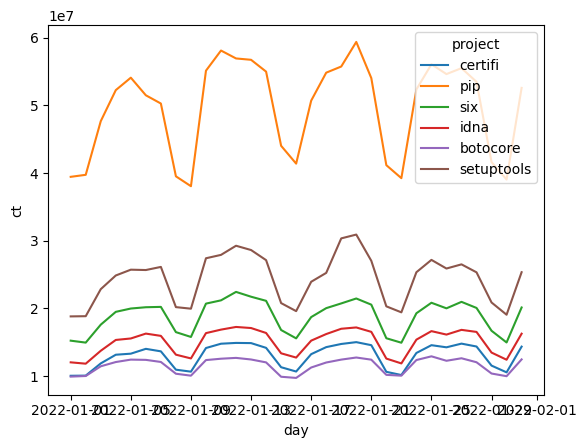

In [8]:
%%fsql bq
SELECT project, DATE(timestamp) AS day, COUNT(project) AS ct
  FROM `{{table}}`
 WHERE project IN (SELECT project FROM projects)
   AND timestamp > '{{start_date}}'
   AND timestamp < '{{end_date}}'
 GROUP BY day, project
 ORDER BY day
OUTPUT USING sns:lineplot(x="day",y="ct",hue="project")

### Productionizing SQL Queries

To use the BigQuery integration in Python scripts, we can put everything together when done iterating using the `fugue_sql` function. We just need to remove the intermediate `YIELD` keywords.

In [9]:
import fugue.api as fa

res = fa.fugue_sql("""
SELECT country_code, project, COUNT(project) AS ct
  FROM `{{table}}`
 WHERE timestamp > '{{start_date}}'
   AND timestamp < '{{end_date}}'
   AND country_code IN ("US", "IE", "NL")
 GROUP BY country_code, project

projects = TAKE {{n}} ROWS PREPARTITION BY country_code PRESORT ct DESC

SELECT project, DATE(timestamp) AS day, COUNT(project) AS ct
  FROM `{{table}}`
 WHERE project IN (SELECT project FROM projects)
   AND timestamp > '{{start_date}}'
   AND timestamp < '{{end_date}}'
 GROUP BY day, project
 ORDER BY day
""", engine="bq", table=table, n=n, start_date=start_date, end_date=end_date)

We can convert this BigQuery Table result to a Pandas DataFrame.

In [10]:
fa.as_pandas(res).head()

,project,day,ct
0,certifi,2022-01-01,10036933
1,pip,2022-01-01,39428581
2,six,2022-01-01,15224135
3,idna,2022-01-01,12021687
4,setuptools,2022-01-01,18808658


### Iterating on Big Data

One of the common use cases is to sample the BigQuery table into a smaller DataFrame that can be worked on using DuckDB. This allows users to prototype SQL queries before running on the full table.

In [11]:
%%fsql bq
SELECT country_code, project, timestamp
  FROM `{{table}}`
 WHERE timestamp > '{{start_date}}'
   AND timestamp < '{{end_date}}'
 SAMPLE 0.0001 PERCENT
  YIELD LOCAL DATAFRAME AS test

Now we can use DuckDB for further iteration. This prevents us from having to query the table.

In [12]:
%%fsql duckdb
SELECT *
  FROM test
 PRINT 5 ROWS

,country_code:str,project:str,timestamp:datetime
0,FI,setuptools,2022-01-14 23:52:37
1,UA,aiohttp,2022-01-14 09:08:12
2,CH,azure-storage,2022-01-14 10:59:25
3,IL,botocore,2022-01-14 19:11:04
4,IT,botocore,2022-01-14 15:08:39


## BigQuery for Python Users

The BigQuery extension also has a programmatic API for Python users. It contains a lot of helper functions designed to pull down BigQuery data for further development with minimal lines of code.

### Getting Table Schema

This function get the schema of the table or the query without execution.

In [13]:
import fugue_bigquery.api as fbqa

query = """
SELECT *
  FROM `bigquery-public-data.pypi.simple_requests`
 WHERE timestamp > '2022-01-01'
   AND timestamp < '2022-02-01'
 """

fbqa.get_schema(query)

timestamp:datetime,country_code:str,url:str,project:str,details:{installer:{name:str,version:str},python:str,implementation:{name:str,version:str},distro:{name:str,version:str,id:str,libc:{lib:str,version:str}},system:{name:str,release:str},cpu:str,openssl_version:str,setuptools_version:str,rustc_version:str},tls_protocol:str,tls_cipher:str

Or for smaller tables, the table name can be used directly.

In [14]:
fbqa.get_schema("bigquery-public-data.usa_names.usa_1910_2013")

state:str,gender:str,year:long,name:str,number:long

### Loading a Table with Python

This function loads the table under the [execution engine context](../../quick_look/ten_minutes.ipynb#engine-context). 

* If the engine is `BigQueryExecutionEngine`, it will return `BigQueryDataFrame` or the underlying Ibis table, depending on `as_fugue`.
* If the engine is not a distributed engine (like Pandas), then it will load the entire result as a local dataframe.
* If the engine is a distributed engine, it will use the engine to distributedly load the table content.

This will return as Ibis table. This table will be compatible with any succeeding Fugue API call. We use a smaller table here because we'll be materializing the data.

In [15]:
# Ibis table
fbqa.load_table("bigquery-public-data.usa_names.usa_1910_2013")  

BigQueryTable: bigquery-public-data.usa_names.usa_1910_2013
  state  string
  gender string
  year   int64
  name   string
  number int64

Notice the `sample` parameter can effectively reduce the size of data loaded so it saves cost. Use it when you load the table with Pandas to reduce the data transfer.

In [16]:
# Pandas DataFrame
df = fbqa.load_table("bigquery-public-data.usa_names.usa_1910_2013", sample=0.0001, engine="pandas")
df.head()

,state,gender,year,name,number
0,AL,F,1910,Sadie,40
1,AL,F,1910,Mary,875
2,AR,F,1910,Vera,39
3,AR,F,1910,Marie,78
4,AR,F,1910,Lucille,66


You can use `columns` and `row_filter` to futher subset the data. `row_filter` resembles a SQL `WHERE` clause.

In [17]:
df = fbqa.load_table("bigquery-public-data.usa_names.usa_1910_2013", 
                     sample=0.0001, 
                     columns=["state", "gender","name"],
                     row_filter="name='Mary'",
                     engine="pandas")
df.head()

,state,gender,name
0,OR,F,Mary
1,DE,F,Mary
2,UT,F,Mary
3,SD,F,Mary
4,HI,F,Mary


### Loading a Table with SQL Query

It is similar to load_table, but the input will be a SQL query. It follows similar rules to `load_table` when deciding how to materialize the table (Ibis, Pandas, or Spark/Dask/Ray).

In [18]:
# Ibis table
fbqa.load_sql("""
SELECT COUNT(*) AS ct
FROM `bigquery-public-data.usa_names.usa_1910_2013`
WHERE state='CA'
""")  

SQLQueryResult
  query: 'SELECT COUNT(*) AS ct FROM `bigquery-public-data.usa_names.usa_1910_2013` …'
  schema:
    ct int64

In [19]:
# Pandas DataFrame
fbqa.load_sql("""
SELECT name
FROM `bigquery-public-data.usa_names.usa_1910_2013` TABLESAMPLE SYSTEM (1 PERCENT)
WHERE state='CA'
""", engine="pandas").head()

,name
0,Gertrude
1,Beatrice
2,Alice
3,Phyllis
4,Vera


### Combining BigQuery and Distributed Compute

One of the strengths of FugueSQL is being able to seamlessly combine Python and SQL expressions. In the example below, we want to get the median value of each state in the data. This function is easy to express in Pandas, but will take a lot more code in SQL. We can use the `transform()` function in the Fugue API and apply this function on the BigQuery table using Spark/Dask/Ray as the backend.

First, we need to create the dataset for persisting intermediate data. Below is an example where we create the `FUGUE_TEMP_DATASET` under the `fugue-analytics` project. It is also highly recommended to set a table expiry to automatically clean up older tables.

![img](../../../images/warehouses/create_bigquery_dataset.png)

Now we can use Spark, Dask, or Ray to consume the BigQuery table and run Python libraries on it. This set-up can be used for distributed profiling or machine learning inference on top of BigQuery data. We'll use the names table because it's smaller than the pypi requests.

In [21]:
import pandas as pd
from typing import List, Any

# schema: *
def median(df:pd.DataFrame) -> List[List[Any]]:
    return [[df.state.iloc[0], df.number.median()]]

fa.transform(
    ("bq", """SELECT state, number
    FROM `bigquery-public-data.usa_names.usa_1910_2013` TABLESAMPLE SYSTEM (1 PERCENT)"""),
    median,
    partition="state",
    engine="dask"
).compute().head()

,state,number
0,AK,9
1,AL,13
2,AR,12
3,AZ,12
4,CA,13


## BigQuery with Broader Fugue API

You can use the tuple `("bq", table_or_sql)` to represent a dataframe that can be used by any function in the standalone Fugue API:

In [ ]:
import fugue.api as fa

fa.show(("bq","bigquery-public-data.pypi.simple_requests"), n=5)

,timestamp:datetime,country_code:str,url:str,project:str,"details:{installer:{name:str,version:str},python:str,implementation:{name:str,version:str},distro:{name:str,version:str,id:str,libc:{lib:str,version:str}},system:{name:str,release:str},cpu:str,openssl_version:str,setuptools_version:str,rustc_version:str}",tls_protocol:str,tls_cipher:str
0,2021-01-16 05:06:46,US,/simple/ab-calc/,ab-calc,None,TLSv1.3,AES256-GCM
1,2021-01-16 05:07:16,US,/simple/abraia/,abraia,None,TLSv1.3,AES256-GCM
2,2021-01-16 05:05:53,US,/simple/15five-snowplow-tracker/,15five-snowplow-tracker,None,TLSv1.3,AES256-GCM
3,2021-01-16 05:06:55,US,/simple/abduy-dist/,abduy-dist,None,TLSv1.3,AES256-GCM
4,2021-01-16 20:20:59,US,/simple/4nil0cin/,4nil0cin,None,TLSv1.3,AES128-GCM


In [ ]:
fa.show(("bq",query))

,timestamp:datetime,country_code:str,url:str,project:str,"details:{installer:{name:str,version:str},python:str,implementation:{name:str,version:str},distro:{name:str,version:str,id:str,libc:{lib:str,version:str}},system:{name:str,release:str},cpu:str,openssl_version:str,setuptools_version:str,rustc_version:str}",tls_protocol:str,tls_cipher:str
0,2022-01-31 18:23:55,GB,/simple/ajpy/,ajpy,"{'installer': {'name': 'pip', 'version': '20.0...",TLSv1.3,AES256-GCM
1,2022-01-31 18:49:52,US,/simple/akamai-edgeauth/,akamai-edgeauth,"{'installer': {'name': 'pip', 'version': '20.2...",TLSv1.2,ECDHE-RSA-AES128-GCM-SHA256
2,2022-01-31 18:58:27,US,/simple/ajpy/,ajpy,"{'installer': {'name': 'pip', 'version': '20.0...",TLSv1.3,AES256-GCM
3,2022-01-31 18:21:33,JP,/simple/aiosqlite/,aiosqlite,"{'installer': {'name': 'pip', 'version': '22.0...",TLSv1.3,AES256-GCM
4,2022-01-31 17:59:41,US,/simple/aiosqlite/,aiosqlite,"{'installer': {'name': 'pip', 'version': '20.1...",TLSv1.3,AES256-GCM
5,2022-01-31 17:59:41,US,/simple/ajpy/,ajpy,"{'installer': {'name': 'pip', 'version': '20.1...",TLSv1.3,AES256-GCM
6,2022-01-31 19:10:02,US,/simple/ajpy/,ajpy,"{'installer': {'name': 'pip', 'version': '20.1...",TLSv1.3,AES256-GCM
7,2022-01-31 19:10:02,US,/simple/aiosqlite/,aiosqlite,"{'installer': {'name': 'pip', 'version': '20.1...",TLSv1.3,AES256-GCM
8,2022-01-31 19:09:41,US,/simple/aiosqlite/,aiosqlite,"{'installer': {'name': 'pip', 'version': '20.1...",TLSv1.3,AES256-GCM
9,2022-01-31 19:09:41,US,/simple/ajpy/,ajpy,"{'installer': {'name': 'pip', 'version': '20.1...",TLSv1.3,AES256-GCM
